In [27]:
import json
import pandas as pd
import numpy as np

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

In [2]:
## Load in Test Set
X_test_path = "X_test_enc.parquet"
X_test = pd.read_parquet(X_test_path)

y_test_path = "y_test.parquet"
y_test = pd.read_parquet(y_test_path)
y_test = pd.DataFrame(y_test['label'].astype(int)) ## convert labels to int for roc auc calculation

## Load in Validation Set
X_val_path = "X_val_enc.parquet"
X_val = pd.read_parquet(X_val_path)

y_val_path = "y_val.parquet"
y_val = pd.read_parquet(y_val_path)
y_val = pd.DataFrame(y_val['label'].astype(int))

y_train_path = "y_train.parquet"
y_train = pd.read_parquet(y_train_path)
y_train = pd.DataFrame(y_train['label'].astype(int))

In [3]:
## function for basic classification
def random_forest(x_train, y_train, x_val, y_val, x_test, y_test, variable, 
                    n_estimators = 100, max_features = "sqrt", max_depth = None,
                    min_samples_split = 2, min_samples_leaf = 1, bootstrap = True):
    ## create classifier
    clf = RandomForestClassifier(random_state = 1, n_estimators = n_estimators, max_features = max_features, 
                                    max_depth = max_depth, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, bootstrap = bootstrap)

    ## train the model
    clf.fit(x_train, y_train)

    ## get validation and test predicition
    y_val_pred = clf.predict(x_val)
    print('Accuracy of random forest classifier on validation set using {}: {:.2f}'.format(variable, metrics.accuracy_score(y_val, y_val_pred)))
   
    y_test_pred = clf.predict(x_test)
    print('Accuracy of random forest classifier on test set using {}: {:.2f}'.format(variable, metrics.accuracy_score(y_test, y_test_pred)))

    ## define metrics for roc
    y_test_pred_proba = clf.predict_proba(x_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
    rf_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
    
    ## create roc curve   
    plt.figure()
    plt.plot(fpr, tpr, label = 'Random Forest Classifier (area = %0.2f)' % rf_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc = "lower right")
    plt.show()

    ## define metric for precision and recall
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_proba)
    auc_precision_recall = auc(recall, precision)

    ## create pr curve   
    plt.figure()
    plt.plot(recall, precision, label = 'Random Forest Classifier (area = %0.2f)' % auc_precision_recall)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall')
    plt.legend(loc = "lower right")
    plt.show()

In [4]:
## defining param_grid

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(200, 300, num = 11)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [5]:
## function for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV


def params_tuning(param_grid, X_train, y_train):
    rf = RandomForestClassifier(random_state = 1)

    ## random search of parameters using 3 fold cross validation
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 50, cv = 3, random_state = 7, n_jobs = -1)
    rf_random.fit(X_train, y_train)

    return rf_random.best_params_

In [6]:
## function for feature selection
from sklearn.feature_selection import SelectFromModel

def var_selection(X_train, y_train, rf):
    sel = SelectFromModel(rf)
    sel.fit(X_train, y_train)

    return X_train.columns[(sel.get_support())]

In [13]:
## define columns to drop
cols_to_drop_50 = ['dwelling_time_-1_25', 'dwelling_time_-1_75', 'dwelling_time_-1_mean', 'std_-1_25', 'std_-1_75', 'std_-1_mean', 'mean_-1_25', 'mean_-1_75', 'mean_-1_mean',
                'dwelling_time_0_25', 'dwelling_time_0_75', 'dwelling_time_0_mean', 'std_0_25', 'std_0_75', 'std_0_mean', 'mean_0_25', 'mean_0_75', 'mean_0_mean',
                'dwelling_time_+1_25', 'dwelling_time_+1_75', 'dwelling_time_+1_mean', 'std_+1_25', 'std_+1_75', 'std_+1_mean', 'mean_+1_25', 'mean_+1_75', 'mean_+1_mean']

## dropping columns from X_validation set
X_val_50 = X_val.drop(columns = cols_to_drop_50, axis = 1)

## dropping columns from X_test set
X_test_50 = X_test.drop(columns = cols_to_drop_50, axis = 1)

## Load X_train_50
X_train_50_path = "X_train_50.parquet" ## to edit file path
X_train_50 = pd.read_parquet(X_train_50_path)

In [14]:
## check if training data are the same len
print(f"Number of Rows for X_train_50 and y_train: {len(X_train_50)}, {len(y_train)}")

## check if validation data are the same len
print(f"Number of Rows for X_val_50 and y_val: {len(X_val_50)}, {len(y_val)}")

## check if test data are the same len
print(f"Number of Rows for X_test_50 and y_test: {len(X_test_50)}, {len(y_test)}")

Number of Rows for X_train_50 and y_train: 30406, 30406
Number of Rows for X_val_50 and y_val: 12143, 12143
Number of Rows for X_test_50 and y_test: 11825, 11825


<ipython-input-3-b649f2bdef8a>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


Accuracy of random forest classifier on validation set using 50th quantile: 0.95
Accuracy of random forest classifier on test set using 50th quantile: 0.95


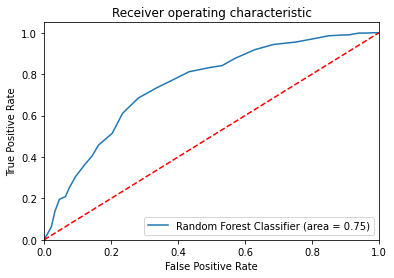

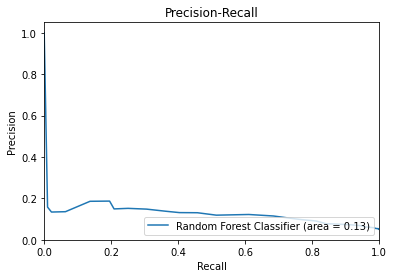

In [15]:
random_forest(X_train_50, y_train, X_val_50, y_val, X_test_50, y_test, "50th quantile")

<ipython-input-16-a5f1a169cd0d>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_fs_50.fit(X_train_50, y_train)
/Users/xinrantao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:355: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


Index(['reads_count', 'dwelling_time_-1_50', 'std_-1_50', 'mean_-1_50',
       'dwelling_time_0_50', 'std_0_50', 'mean_0_50', 'dwelling_time_+1_50',
       'std_+1_50', 'mean_+1_50', 'position_1_G', 'position_5_T'],
      dtype='object')


<ipython-input-3-b649f2bdef8a>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


Accuracy of random forest classifier on validation set using 50th quantile: 0.95
Accuracy of random forest classifier on test set using 50th quantile: 0.95


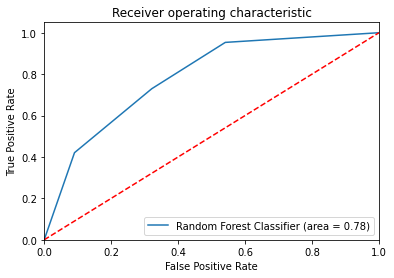

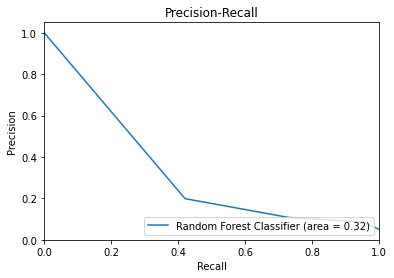

In [16]:
rf_fs_50 = RandomForestClassifier(random_state = 1)
rf_fs_50.fit(X_train_50, y_train)

best_var_50 = var_selection(X_train_50, y_train, rf_fs_50)
print(best_var_50)

random_forest(X_train_50[list(best_var_50)], y_train, X_val_50[list(best_var_50)], y_val, X_test_50[list(best_var_50)], y_test, "50th quantile")

<ipython-input-3-b649f2bdef8a>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


Accuracy of random forest classifier on validation set using 50th quantile: 0.88
Accuracy of random forest classifier on test set using 50th quantile: 0.88


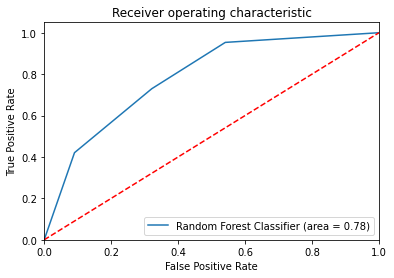

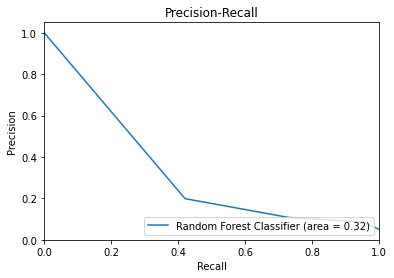

In [18]:
random_forest(X_train_50[list(best_var_50)], y_train, 
                X_val_50[list(best_var_50)], y_val, 
                X_test_50[list(best_var_50)], y_test, "50th quantile",
                n_estimators = 210, min_samples_split = 2, min_samples_leaf = 1, 
                max_features = 'sqrt', max_depth = 100, bootstrap = False)

In [19]:
clf = RandomForestClassifier(random_state = 1, n_estimators = 210, min_samples_split = 2, min_samples_leaf = 1, 
                max_features = 'sqrt', max_depth = 100, bootstrap = False)


<ipython-input-22-9460d7b04476>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train_50[list(best_var_50)], y_train)


Accuracy of random forest classifier on validation set using 50th percentile: 0.88
Accuracy of random forest classifier on test set using 50th percentile: 0.88


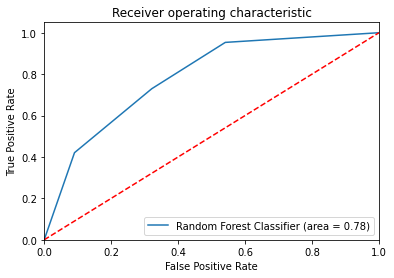

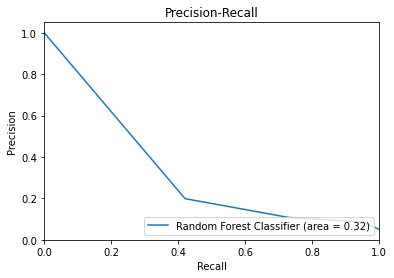

In [22]:
##here im just checking the clf model we fitting is the right one
clf.fit(X_train_50[list(best_var_50)], y_train)
variable = "50th percentile"
    ## get validation and test predicition
y_val_pred = clf.predict(X_val_50[list(best_var_50)])
print('Accuracy of random forest classifier on validation set using {}: {:.2f}'.format(variable, metrics.accuracy_score(y_val, y_val_pred)))
   
y_test_pred = clf.predict(X_test_50[list(best_var_50)])
print('Accuracy of random forest classifier on test set using {}: {:.2f}'.format(variable, metrics.accuracy_score(y_test, y_test_pred)))

    ## define metrics for roc
y_test_pred_proba = clf.predict_proba(X_test_50[list(best_var_50)])[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
rf_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
    
    ## create roc curve   
plt.figure()
plt.plot(fpr, tpr, label = 'Random Forest Classifier (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = "lower right")
plt.show()

    ## define metric for precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_proba)
auc_precision_recall = auc(recall, precision)

    ## create pr curve   
plt.figure()
plt.plot(recall, precision, label = 'Random Forest Classifier (area = %0.2f)' % auc_precision_recall)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall')
plt.legend(loc = "lower right")
plt.show()

In [25]:
data_df11 = pd.read_parquet("dataset1_1.parquet")
data_df12 = pd.read_parquet("dataset1_2.parquet")
data_df13 = pd.read_parquet("dataset1_3.parquet")
data_df14 = pd.read_parquet("dataset1_4.parquet")
data_df15 = pd.read_parquet("dataset1_5.parquet")
data_df16 = pd.read_parquet("dataset1_6.parquet")
data_df17 = pd.read_parquet("dataset1_7.parquet")
data_df18 = pd.read_parquet("dataset1_8.parquet")

In [29]:
data_df21 = pd.read_parquet("dataset2_1.parquet")
data_df22 = pd.read_parquet("dataset2_2.parquet")
data_df23 = pd.read_parquet("dataset2_3.parquet")
data_df24 = pd.read_parquet("dataset2_4.parquet")
data_df25 = pd.read_parquet("dataset2_5.parquet")
data_df26 = pd.read_parquet("dataset2_6.parquet")
data_df27 = pd.read_parquet("dataset2_7.parquet")

In [26]:
raw_df =  pd.concat([data_df11, data_df12, data_df13,data_df14,data_df15,data_df16,data_df17,data_df18])

In [30]:
raw_df2 = pd.concat([data_df21, data_df22, data_df23,data_df24,data_df25 ,data_df26 ,data_df27 ])

In [32]:
def get_percent(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [33]:
def feature_eng(df):
    df = pd.DataFrame(df.groupby([ 'transcript', 'position', 'nucleotides', 'reads_count'], as_index=False)
                            .agg({'dwellingtime_-1': [get_percent(25), get_percent(50), get_percent(75), np.mean],
                                    'std_-1': [get_percent(25), get_percent(50), get_percent(75), np.mean],
                                    'mean_-1': [get_percent(25), get_percent(50), get_percent(75), np.mean],
                                    'dwellingtime_0': [get_percent(25), get_percent(50), get_percent(75), np.mean],
                                    'std_0': [get_percent(25), get_percent(50), get_percent(75), np.mean],
                                    'mean_0': [get_percent(25), get_percent(50), get_percent(75), np.mean],
                                    'dwellingtime_+1': [get_percent(25), get_percent(50), get_percent(75), np.mean],
                                    'std_+1': [get_percent(25), get_percent(50), get_percent(75), np.mean],
                                    'mean_+1': [get_percent(25), get_percent(50), get_percent(75), np.mean]}))
    df.columns = ['transcript', 'position', 'nucleotides', 'reads_count',
                        'dwelling_time_-1_25', 'dwelling_time_-1_50', 'dwelling_time_-1_75', 'dwelling_time_-1_mean',
                        'std_-1_25', 'std_-1_50', 'std_-1_75', 'std_-1_mean',
                        'mean_-1_25', 'mean_-1_50', 'mean_-1_75', 'mean_-1_mean',
                        'dwelling_time_0_25', 'dwelling_time_0_50', 'dwelling_time_0_75', 'dwelling_time_0_mean',
                        'std_0_25', 'std_0_50', 'std_0_75', 'std_0_mean',
                        'mean_0_25', 'mean_0_50', 'mean_0_75', 'mean_0_mean',
                        'dwelling_time_+1_25', 'dwelling_time_+1_50', 'dwelling_time_+1_75', 'dwelling_time_+1_mean',
                        'std_+1_25', 'std_+1_50', 'std_+1_75', 'std_+1_mean',
                        'mean_+1_25', 'mean_+1_50', 'mean_+1_75', 'mean_+1_mean']
    return df

In [34]:
percentiles1 = feature_eng(raw_df)

In [35]:
percentiles2 = feature_eng(raw_df2)

In [67]:
X_test_enc_1 = pd.read_parquet("X_test_enc_1.parquet")
X_test_enc_2 = pd.read_parquet("X_test_enc_2.parquet")

In [68]:
X_test_50.shape

(11825, 38)

In [43]:
percentiles1.shape

(90810, 40)

In [46]:
X_test_50.head()

,reads_count,dwelling_time_-1_50,std_-1_50,mean_-1_50,dwelling_time_0_50,std_0_50,mean_0_50,dwelling_time_+1_50,std_+1_50,mean_+1_50,...,position_4_G,position_4_T,position_5_A,position_5_C,position_5_G,position_5_T,position_6_A,position_6_C,position_6_G,position_6_T
0,28.0,0.007705,3.010,119.0,0.006970,7.680,123.0,0.006395,2.630,87.6,...,0,0,0,0,0,1,0,1,0,0
1,25.0,0.005980,3.500,119.0,0.006970,4.610,125.0,0.004720,2.860,86.7,...,0,0,0,0,0,1,0,0,0,1
2,30.0,0.007245,5.685,130.0,0.006655,3.375,104.0,0.006640,3.555,94.4,...,0,0,0,0,0,1,0,0,0,1
3,29.0,0.005930,3.860,102.0,0.007300,8.430,118.0,0.005310,2.880,77.2,...,0,0,0,1,0,0,0,0,0,1
4,29.0,0.006970,3.370,108.0,0.009770,3.840,105.0,0.006310,2.510,92.3,...,0,0,0,0,0,1,0,1,0,0


In [66]:
X_test_enc_1.head()

,reads_count,dwelling_time_-1_25,dwelling_time_-1_50,dwelling_time_-1_75,dwelling_time_-1_mean,std_-1_25,std_-1_50,std_-1_75,std_-1_mean,mean_-1_25,...,position_4_G,position_4_T,position_5_A,position_5_C,position_5_G,position_5_T,position_6_A,position_6_C,position_6_G,position_6_T
0,165.0,0.004320,0.006310,0.011000,0.008722,2.860,3.390,4.3800,3.990545,123.0,...,0,0,0,1,0,0,1,0,0,0
1,166.0,0.003650,0.005640,0.007970,0.006292,2.085,2.805,3.3675,2.849892,107.0,...,0,0,0,0,0,1,0,0,1,0
2,169.0,0.004100,0.005980,0.009300,0.007237,1.960,2.430,3.1800,2.782710,105.0,...,0,0,1,0,0,0,0,0,1,0
3,184.0,0.005885,0.009385,0.013425,0.010299,4.355,5.475,7.5725,6.042386,128.0,...,0,0,1,0,0,0,0,0,0,1
4,177.0,0.005810,0.010000,0.014600,0.011535,5.140,6.260,6.9400,6.031751,116.0,...,0,0,1,0,0,0,1,0,0,0


In [69]:
X_test_1_50 = X_test_enc_1.drop(columns = cols_to_drop_50, axis = 1)

In [70]:
X_test_1_50.shape

(90810, 38)

In [71]:
y_test_pred_proba = clf.predict_proba(X_test_1_50[list(best_var_50)])[:,1]

In [72]:
id_val_1.shape

(90810, 2)

In [73]:
y_test_pred_proba

array([0.29047619, 0.38095238, 0.29047619, ..., 0.45714286, 0.45714286,
       0.29047619])

In [74]:
res = pd.DataFrame(y_test_pred_proba,columns=['score'])

In [75]:
pd.concat([id_val_1, res], axis=1)

,transcript,position,score
0,ENST00000000233,244,0.290476
1,ENST00000000233,261,0.380952
2,ENST00000000233,316,0.290476
3,ENST00000000233,332,0.457143
4,ENST00000000233,368,0.457143
...,...,...,...
90805,ENST00000641834,610,0.519048
90806,ENST00000641834,697,0.290476
90807,ENST00000641834,864,0.457143
90808,ENST00000641834,926,0.457143


In [76]:
X_test_2_50 = X_test_enc_2.drop(columns = cols_to_drop_50, axis = 1)

In [77]:
X_test_2_50.shape

(98830, 38)

In [78]:
y_test_pred_proba2 = clf.predict_proba(X_test_2_50[list(best_var_50)])[:,1]

In [79]:
res2 = pd.DataFrame(y_test_pred_proba2,columns=['score'])

In [80]:
pd.concat([id_val_2, res2], axis=1)

,transcript,position,score
0,AT1G01050.1,155,0.380952
1,AT1G01050.1,165,0.290476
2,AT1G01050.1,347,0.290476
3,AT1G01050.1,435,0.290476
4,AT1G01050.1,549,0.290476
...,...,...,...
98825,AT5G67590.1,367,0.380952
98826,AT5G67590.1,444,0.290476
98827,AT5G67590.1,465,0.380952
98828,AT5G67590.1,663,0.290476
